In [1]:
import os
import itertools

import pandas
import matplotlib
import seaborn
import lifelines
from scipy.stats import pearsonr, spearmanr

from lifelines.statistics import logrank_test

In [2]:
FIG_SIZE = (6, 2.5)
FIG_SIZE_WIDE = (14, 2.5)
FIGURE_PATH = '../figures'

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2013-01-01'), pandas.to_datetime('2017-12-31')
CENSOR_DATE = pandas.to_datetime('2018-03-15')
P_VALUE = 0.05  # Not corrected

PALETTE = seaborn.color_palette(n_colors=len(ECOSYSTEMS))
SEC_PALETTE = seaborn.color_palette('muted')

COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

In [3]:
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

def _savefig(fig, name):
    fig.savefig(
        os.path.join(FIGURE_PATH, '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

# Disable figure export
SAVEFIG = True
savefig = _savefig if SAVEFIG else lambda x, y: None

# Load and transform data

In [4]:
df_versions = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_versions[ecosystem] = (
        pandas.read_csv(
            '../data/{}-versions.csv.gz'.format(ecosystem),
        )
        .assign(
            date=lambda d: pandas.to_datetime(d['date'], infer_datetime_format=True),
        )
    )
    
    print('.. identify next release')
    df_versions[ecosystem] = (
        df_versions[ecosystem]
        .merge(
            (
                df_versions[ecosystem]
                .assign(rank=lambda d: d['rank'] - 1)
                .rename(columns={'date': 'next_date'})
                [['package', 'rank', 'next_date']]
            ),
            how='left',
            on=['package', 'rank']
        )
    )
    
print('Done!')

Loading Cargo
.. identify next release
Loading NPM
.. identify next release
Loading Packagist
.. identify next release
Loading Rubygems
.. identify next release
Done!


In [5]:
mask_compliant = {
    'Semver': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_patch']),
    'Cargo': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_minor'] & d['allows_patch']),
    'NPM': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_minor'] & d['allows_patch']),
    'Packagist': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_minor'] & d['allows_patch']),
    'Rubygems': lambda d: (~d['allows_major'] & d['allows_minor']),
}
 
mask_permissive = {
    'Semver': lambda d: d['allows_major'] | (d['dev'] & d['allows_patch']),
    'Cargo': lambda d: d['allows_major'] | (d['dev'] & d['allows_minor']),
    'NPM': lambda d: d['allows_major'] | (d['dev'] & d['allows_minor']),
    'Packagist': lambda d: d['allows_major'] | (d['dev'] & d['allows_minor']),
    'Rubygems': lambda d: d['allows_major'],
}

mask_restrictive = {
    'Semver': lambda d: ~d['allows_minor'] & ~d['dev'],
    'Cargo': lambda d: ~d['allows_patch'] | (~d['dev'] & ~d['allows_minor']),
    'NPM': lambda d: ~d['allows_patch'] | (~d['dev'] & ~d['allows_minor']),
    'Packagist': lambda d: ~d['allows_patch'] | (~d['dev'] & ~d['allows_minor']),
    'Rubygems': lambda d: ~d['allows_minor'],
}

In [6]:
df_dependencies = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_dependencies[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependencies.csv.gz'.format(ecosystem),
        )
        .merge(
            df_versions[ecosystem][['package', 'version', 'rank', 'date', 'next_date']],
            how='left',
            on=['package', 'version']
        )
       .assign(**{
            'compliant': mask_compliant['Semver'],
            'permissive': mask_permissive['Semver'],
            'restrictive': mask_restrictive['Semver'],
        })
        #.assign(**{
        #    'semver_compliant': mask_semver['Semver'],
        #    'semver_permissive': mask_permissive['Semver'],
        #    'semver_restrictive': mask_restrictive['Semver'],
        #})
    )    
    
print('Done!')

Loading Cargo
Loading NPM
Loading Packagist
Loading Rubygems
Done!


In [7]:
df_constraints = dict()

for ecosystem in ECOSYSTEMS:
    print('Considering', ecosystem)
    
    df_tmp = df_dependencies[ecosystem].sort_values('rank')
    
    df_constraints[ecosystem] = (
        df_tmp
        .drop_duplicates(['package', 'target', 'constraint'], keep='first')
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target', 'constraint'], keep='last')
                [['package', 'target', 'constraint', 'rank', 'next_date']]
                .assign(next_rank=lambda d: (d['rank'] + 1).where(~d['next_date'].isnull()))
                .rename(columns={'next_date': 'constraint_next_date', 'next_rank': 'constraint_next_rank'})
                [['package', 'target', 'constraint', 'constraint_next_date', 'constraint_next_rank']]
            ),
            how='left',
            on=['package', 'target', 'constraint']
        )
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target'], keep='first')
                .assign(constraint_is_new=True)
                [['package', 'target', 'rank', 'constraint_is_new']]
            ),
            how='left',
            on=['package', 'target', 'rank']
        )
        .fillna({'constraint_is_new': False})
    )
print('Done!')

Considering Cargo
Considering NPM
Considering Packagist
Considering Rubygems
Done!


# Overview

## Number of packages, releases and dependencies

[None,
 Text(0,0.5,'packages and releases'),
 (734869.0, 736694.0),
 Text(0.5,0,'')]

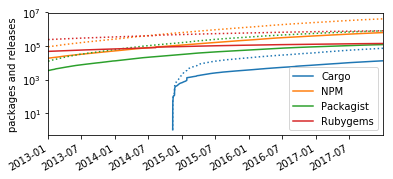

In [8]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()

for ecosystem in ECOSYSTEMS:
    df_tmp = (
        df_versions[ecosystem]
        .set_index('date')
        .sort_index()
    )
    
    data[ecosystem] = (
        df_tmp
        .drop_duplicates(['package'], keep='first')
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
        ,
        df_tmp
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()        
    )
    
    data[ecosystem][0].plot(ax=ax, color=COLORS[ecosystem])
    data[ecosystem][1].plot(ax=ax, legend=False, style=':', color=COLORS[ecosystem])
    
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='packages and releases',
    yscale='log', 
)

#savefig(fig, 'overview_number_packages_releases')

In [9]:
for ecosystem in ECOSYSTEMS:
    print(
        ecosystem, 
        data[ecosystem][0][lambda d: d.index <= pandas.to_datetime(DATE_RANGE[1])].max().values, 
        data[ecosystem][1][lambda d: d.index <= pandas.to_datetime(DATE_RANGE[1])].max().values
    )

Cargo [13064] [73049]
NPM [630432] [4181320]
Packagist [120951] [797561]
Rubygems [141334] [809378]


[None,
 Text(0,0.5,'cumulative number of dependencies'),
 (734869.0, 736694.0),
 Text(0.5,0,'')]

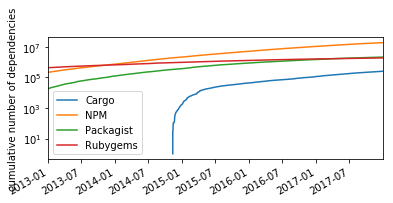

In [10]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .set_index('date')
        .sort_index()
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='cumulative number of dependencies',
    yscale='log', 
)

#savefig(fig, 'overview_number_dependencies')

In [11]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem, data[ecosystem][lambda d: d.index <= pandas.to_datetime(DATE_RANGE[1])].max().values)

Cargo [257302]
NPM [19029814]
Packagist [2167629]
Rubygems [1922572]


## Monthly proportion of parsed dependencies

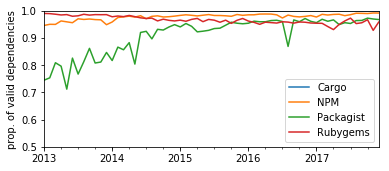

In [12]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(version=1)        
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['empty', 'version']]
        .sum()
        .assign(**{ecosystem: lambda d: (d['version'] - d['empty']) / d['version']})
        [[ecosystem]]
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of valid dependencies',
    ylim=(0.5, 1.00),
)

savefig(fig, 'overview_proportion_valid_dependencies')

In [13]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.999993,0.978316,0.909829,0.966960
std,0.000031,0.011300,0.069609,0.013949
min,0.999837,0.946450,0.712144,0.928383
25%,1.000000,0.975176,0.865587,0.958182
50%,1.000000,0.981921,0.942185,0.965634
75%,1.000000,0.985683,0.960370,0.978888
max,1.000000,0.992288,0.973335,0.990661


Proportion of parsed constraints after and before 2015 for Packagist:

In [14]:
(
    df_dependencies['Packagist']
    .assign(before2015=lambda d: d['date'] <= pandas.to_datetime('2015-01-01'))
    .groupby(['before2015', 'empty'])
    [['version']]
    .count()
)

version
before2015 empty         
False      False  1808952
           True     85846
True       False   328531
           True     50136

## Proportion of packages older than semver

In [15]:
for ecosystem in ECOSYSTEMS:
    _ = df_versions[ecosystem].sort_values('date').drop_duplicates('package', keep='first')
    
    print(
        ecosystem, 
        len(_),
        len(_[lambda d: d['date'] <= pandas.to_datetime('2011-09')]) / len(_),
        len(_[lambda d: d['date'] <= pandas.to_datetime('2013-06')]) / len(_),
    )

Cargo 14491 0.0 0.0
NPM 676277 0.00434437368119868 0.04399084990322013
Packagist 126363 0.0004194265726518047 0.054359266557457486
Rubygems 143737 0.18683428762253282 0.3881672777364214


# Dependency constraint usage

## Monthly proportion of pre-1.0.0 constraints

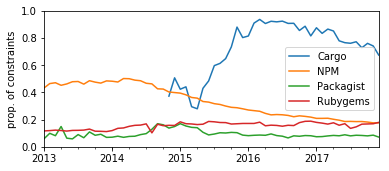

In [16]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(zero=lambda d: d['dev'].astype(int))
        .assign(constraint=1)
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['constraint', 'zero']]
        .sum()
        .assign(**{ecosystem: lambda d: d['zero'] / d['constraint']})
        [[ecosystem]]
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of constraints',
    ylim=(0, 1),
)

savefig(fig, 'dev_proportion_constraints')

In [17]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.727462,0.337873,0.094602,0.154944
std,0.192815,0.116117,0.027945,0.023695
min,0.279651,0.176047,0.058276,0.102568
25%,0.622591,0.226868,0.078071,0.135807
50%,0.776425,0.323098,0.084806,0.159490
75%,0.879634,0.463607,0.102035,0.171580
max,0.937238,0.502245,0.170219,0.188563


In [18]:
for ecosystem in ECOSYSTEMS: 
    print(ecosystem, data[ecosystem].reset_index()[lambda d: d['date'].between(*DATE_RANGE)].iloc[-1][ecosystem])

Cargo 0.6732227965362153
NPM 0.176345993561559
Packagist 0.0712610100473598
Rubygems 0.1801084460944751


## Monthly proportion of required packages with a pre-1.0.0 reverse dependency constraint

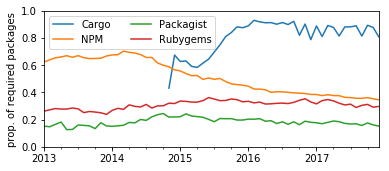

In [19]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .groupby(['target', pandas.Grouper(key='date', freq='1M')])
        .agg({'dev': 'max'})
        .reset_index('target', drop=True)
        .reset_index()
        .assign(required=1)
        .groupby(pandas.Grouper(key='date', freq='1M'))
        .sum()
        [lambda d: d['required'] > 0]
        .assign(**{ecosystem: lambda d: d['dev'] / d['required']})
    )
    data[ecosystem][[ecosystem]].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of required packages',
    ylim=(0, 1),
)

ax.legend(ncol=2, loc='upper left')
savefig(fig, 'dev_proportion_required')

In [20]:
pandas.concat([
    data[ecosystem][[ecosystem]]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.808401,0.516000,0.183493,0.309315
std,0.123758,0.123584,0.027677,0.029918
min,0.431818,0.346077,0.126332,0.238658
25%,0.760043,0.396156,0.162453,0.285508
50%,0.877137,0.499807,0.181205,0.315337
75%,0.893720,0.652541,0.203033,0.331748
max,0.930841,0.703922,0.244657,0.362282


In [21]:
for ecosystem in ECOSYSTEMS: 
    print(ecosystem, data[ecosystem].reset_index()[lambda d: d['date'].between(*DATE_RANGE)].iloc[-1][ecosystem])

Cargo 0.8076659822039699
NPM 0.3460771276595745
Packagist 0.1522258414766558
Rubygems 0.297221103503826


## Monthly proportion of post-1.0.0 constraints w.r.t. semver

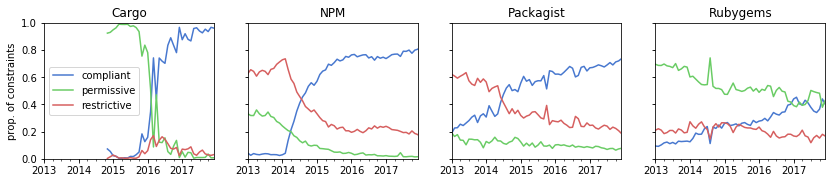

In [22]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['compliant', 'permissive', 'restrictive', 'n']]
        .sum()
        [lambda d: d['n'] > 0]
        .apply(lambda d: d / d['n'], axis=1)
        [['compliant', 'permissive', 'restrictive']]
    )
    
    data[ecosystem].plot(ax=ax, legend=False, color=SEC_PALETTE)
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='prop. of constraints',
        ylim=(0, 1),
    )
    
axes[0].legend(title=None, loc='center left')
savefig(fig, 'usage_compliance_post1')

In [23]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .iloc[-1]
for ecosystem in ECOSYSTEMS], axis=1)

,37,85,76,159
date,2017-12-31 00:00:00,2017-12-31 00:00:00,2017-12-31 00:00:00,2017-12-31 00:00:00
compliant,0.96138,0.806116,0.736668,0.401335
permissive,0.00760066,0.015353,0.0773245,0.431363
restrictive,0.0310189,0.178531,0.186008,0.167302
ecosystem,Cargo,NPM,Packagist,Rubygems


What happens for Cargo in early 2016? It seems to be related with the prohibited use of "*" constraints.

[(0, 1), Text(0,0.5,'prop. of wildcards'), (516, 575)]

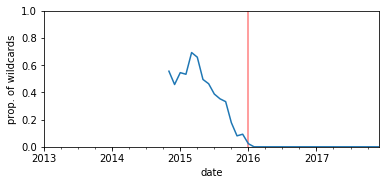

In [24]:
data_temp = (
    df_dependencies['Cargo']
    .assign(wildcard=lambda d: d['constraint'] == '*')
    .groupby(pandas.Grouper(key='date', freq='M'))
    .agg({'package': 'count', 'wildcard': 'sum'})
    .assign(proportion=lambda d: d['wildcard'] / d['package'])
)

ax = data_temp[['proportion']].plot(legend=False)

ax.vlines(pandas.to_datetime('2016-01-22'), 0, 1, colors='r', alpha=0.5)

ax.set(
    xlim=DATE_RANGE,
    ylim=(0, 1), 
    ylabel='prop. of wildcards',
)

In [25]:
for date in ['2015-01-31', '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31']:
    print(date, data_temp.loc[pandas.to_datetime(date)]['proportion'])

2015-01-31 0.5456936226166995
2015-12-31 0.09259259259259259
2016-01-31 0.022795302786092562
2016-02-29 0.0
2016-03-31 0.0


Why are the restrictive constraints err.. restrictive? We know they prevent minor releases to be installed, but what about patches? 

Here we compute the proportion of these constraints that do **not** allow patches:

In [26]:
for ecosystem in ECOSYSTEMS:
    _ = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        [lambda d: d['restrictive']]
        [lambda d: d['date'].between(pandas.to_datetime('2017-12-01'), pandas.to_datetime('2017-12-31'))]
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['allows_patch', 'n']]
        .sum()
        .iloc[0]
    )
    print(ecosystem, 1 - (_['allows_patch'] / _['n']))

Cargo 0.020270270270270285
NPM 0.8267997429407059
Packagist 0.32251655629139075
Rubygems 0.5173524150268336


## Monthly proportion of pre-1.0.0 constraints w.r.t. semver

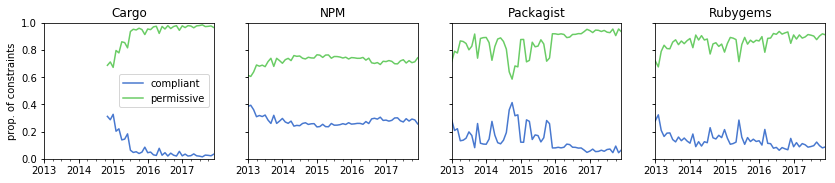

In [27]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: d['dev']]
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['compliant', 'permissive', 'restrictive', 'n',
         'allows_major', 'allows_minor', 'allows_patch']]
        .sum()
        [lambda d: d['n'] > 0]
        .apply(lambda d: d / d['n'], axis=1)
    )
    
    data[ecosystem][['compliant', 'permissive']].plot(ax=ax, legend=False, color=SEC_PALETTE)

    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='prop. of constraints',
        ylim=(0, 1),
    )
    
axes[0].legend(title=None, loc='center right')
savefig(fig, 'usage_compliance_pre1')

In [28]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .iloc[-1]
    for ecosystem in ECOSYSTEMS], axis=1
)

,37,84,70,152
date,2017-12-31 00:00:00,2017-12-31 00:00:00,2017-12-31 00:00:00,2017-12-31 00:00:00
compliant,0.0347991,0.256829,0.0664596,0.0873339
permissive,0.965201,0.743171,0.93354,0.912666
restrictive,0,0,0,0
n,1,1,1,1
allows_major,0,0,0,0
allows_minor,0.00887426,0.00375076,0.137888,0.509086
allows_patch,0.965201,0.743171,0.93354,0.912666
ecosystem,Cargo,NPM,Packagist,Rubygems


# Constraint changes

## Monthly proportion of constraint changes

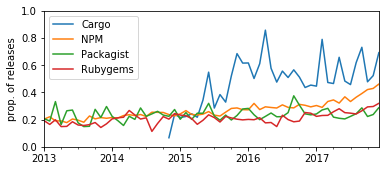

In [29]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()

for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_constraints[ecosystem]
        .assign(changes=1)
        .groupby(pandas.Grouper(key='constraint_next_date', freq='1M'))
        [['changes']]
        .sum()
        .merge(
            (
                df_versions[ecosystem]
                .assign(releases=1)
                .groupby(pandas.Grouper(key='date', freq='1M'))
                [['releases']]
                .sum()
            ),
            how='right',
            left_index=True,
            right_index=True,
        )
        .assign(**{ecosystem: lambda d: d['changes'] / d['releases']})
        [[ecosystem]]
    )
    
    data[ecosystem].plot(ax=ax, legend=False, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of releases',
    ylim=(0, 1),
)

ax.legend(title=None)

savefig(fig, 'change_monthly_evolution')

In [30]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.484797,0.269402,0.237405,0.209728
std,0.173415,0.062413,0.043738,0.041021
min,0.066667,0.178168,0.148733,0.113324
25%,0.397355,0.226728,0.209184,0.181473
50%,0.493202,0.254737,0.233462,0.206887
75%,0.602922,0.296588,0.266381,0.233701
max,0.858378,0.462061,0.375214,0.320042


Number of updates between two changes

In [31]:
for ecosystem in ECOSYSTEMS:
    _ = (
        df_constraints[ecosystem]
        .assign(updates=lambda d: d['constraint_next_rank'] - d['rank'])
        ['updates']
        .mean()
    )
    print(ecosystem, _)

Cargo 3.3545930286889076
NPM 6.92971665940571
Packagist 5.683522197304967
Rubygems 5.328836445925447


## Duration of a constraint w.r.t. semver

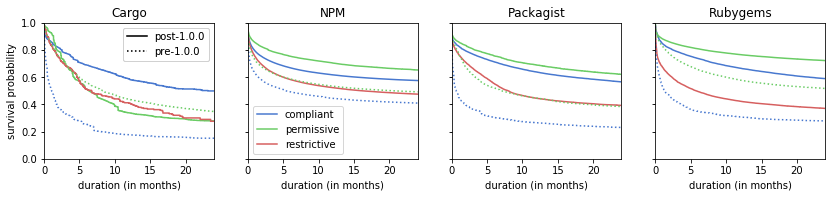

In [32]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_constraints[ecosystem]
        .assign(duration=lambda d: (d['constraint_next_date'].fillna(CENSOR_DATE) - d['date']) / pandas.to_timedelta(30, 'days'))
        .assign(observed=lambda d: ~d['constraint_next_date'].isnull())
    )
    
    kmf = lifelines.KaplanMeierFitter()
    for dev in (False, True):
        for j, constraint_type in enumerate(['compliant', 'permissive', 'restrictive']):
            mask = (lambda d: (d['dev'] == dev) & d[constraint_type])
            try:
                kmf.fit(data[ecosystem][mask]['duration'], data[ecosystem][mask]['observed'], label=constraint_type if not dev else '')
                kmf.plot(ax=ax, c=SEC_PALETTE[j], ci_show=False, legend=False, style=':' if dev else '-')
            except ValueError:
                pass
    ax.set(
        title=ecosystem,
        xlabel='duration (in months)',
        xlim=(0, 24),
        ylabel='survival probability',
        ylim=(0, 1),         
    )
    
legend = axes[0].legend(
    [matplotlib.lines.Line2D([0], [0], color='k'), matplotlib.lines.Line2D([0], [0], color='k', linestyle='dotted')],
    ['post-1.0.0', 'pre-1.0.0'],
)
axes[1].legend()
axes[0].add_artist(legend)

savefig(fig, 'change_constraint_duration')

Delay in days?

In [33]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    
    for dev in (False, True):
        _ = ['compliant', 'permissive', 'restrictive']
        if dev:
            _.remove('restrictive')
            
        for A, B in itertools.combinations(_, 2):
            mask_A = (lambda d: (d['dev'] == dev) & d[A])
            mask_B = (lambda d: (d['dev'] == dev) & d[B])
            
            try:
                test = logrank_test(
                    data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
                    data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
                    alpha=0.95,
                )
                print('({}) {} vs {}: {} ({:e})'.format('pre-1.0.0' if dev else 'post-1.0.0', A, B, (test.p_value < P_VALUE), test.p_value))
            except AssertionError:  # Don't know why lifelines does this?
                print('({}) {} vs {}: passed'.format('pre-1.0.0' if dev else 'post-1.0.0', A, B))
    
    print()
    for A in ['compliant', 'permissive']:
        mask_A = (lambda d: ~d['dev'] & d[A])
        mask_B = (lambda d: d['dev'] & d[A])
        try:
            test = logrank_test(
                data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
                data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
                alpha=0.95,
            )
            print('({}) post-1.0.0 vs. pre-1.0.0: {} ({:e})'.format(A, test.p_value < P_VALUE, test.p_value))
        except (AssertionError, ValueError):  # Don't know why lifelines does this?
            print('({}) post-1.0.0 vs. pre-1.0.0: passed'.format(A))
    
    print()

Cargo
(post-1.0.0) compliant vs permissive: True (5.525982e-125)
(post-1.0.0) compliant vs restrictive: True (2.049930e-18)
(post-1.0.0) permissive vs restrictive: False (6.447385e-01)
(pre-1.0.0) compliant vs permissive: True (0.000000e+00)

(compliant) post-1.0.0 vs. pre-1.0.0: True (0.000000e+00)
(permissive) post-1.0.0 vs. pre-1.0.0: True (2.580311e-12)

NPM
(post-1.0.0) compliant vs permissive: True (0.000000e+00)
(post-1.0.0) compliant vs restrictive: True (0.000000e+00)
(post-1.0.0) permissive vs restrictive: True (0.000000e+00)
(pre-1.0.0) compliant vs permissive: True (0.000000e+00)

(compliant) post-1.0.0 vs. pre-1.0.0: True (0.000000e+00)
(permissive) post-1.0.0 vs. pre-1.0.0: True (0.000000e+00)

Packagist
(post-1.0.0) compliant vs permissive: True (1.967548e-91)
(post-1.0.0) compliant vs restrictive: True (0.000000e+00)
(post-1.0.0) permissive vs restrictive: True (0.000000e+00)
(pre-1.0.0) compliant vs permissive: True (0.000000e+00)

(compliant) post-1.0.0 vs. pre-1.0.0:

Are packages in an initial development phase updated more often?

Cargo: False (6.256423e-02)
NPM: True (0.000000e+00)
Packagist: True (0.000000e+00)
Rubygems: True (2.056110e-203)


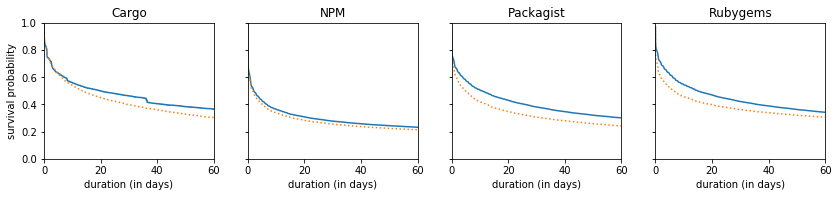

In [34]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_versions[ecosystem]
        .assign(initial=lambda d: d['major'] == 0)
        .assign(observed=lambda d: ~d['next_date'].isnull())
        .assign(duration=lambda d: (d['next_date'].fillna(CENSOR_DATE) - d['date']) / pandas.to_timedelta(1, 'days'))
        [['initial', 'duration', 'observed']]
    )

    kmf = lifelines.KaplanMeierFitter()
    for initial in (False, True):
        mask = lambda d: (d['initial'] == initial)
        kmf.fit(data[ecosystem][mask]['duration'], data[ecosystem][mask]['observed'], label='initial' if initial else 'production')
        kmf.plot(ax=ax, ci_show=False, legend=False, style=':' if initial else '-')
        
    mask_A = lambda d: d['initial']
    mask_B = lambda d: ~d['initial']
    test = logrank_test(
        data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
        data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
        alpha=0.95,
    )
    print('{}: {} ({:e})'.format(ecosystem, test.p_value < P_VALUE, test.p_value))
        
    ax.set(
        title=ecosystem,
        xlabel='duration (in days)',
        xlim=(0, 60),
        ylabel='survival probability',
        ylim=(0, 1),         
    )

## Proportion of changes w.r.t. original and new constraint semantics

Restricted to 2017 (to limit the impact of some ecosystem-specific changes).

In [35]:
data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_constraints[ecosystem]
        [lambda d: ~d['dev']]
        [lambda d: d['constraint_next_date'].between(pandas.to_datetime('2017-01-01'), pandas.to_datetime('2018-01-01'))]
        .assign(
           kind=lambda d: d[['compliant', 'permissive', 'restrictive']].apply(lambda s: s.values.argmax(), axis=1)
        )
        .pipe(lambda d: 
            d[['package', 'target', 'kind', 'constraint_next_rank']]
            .merge(
                d[['package', 'target', 'kind', 'rank']],
                how='inner',
                left_on=['package', 'target', 'constraint_next_rank'],
                right_on=['package', 'target', 'rank'],
                suffixes=('', '_new'),
            )        
        )
        .assign(n=1)
        .groupby(['kind', 'kind_new'], as_index=False)
        [['n']]
        .count()
        .replace({
            'kind': {0: 'compliant', 1: 'permissive', 2: 'restrictive'},
            'kind_new': {0: 'compliant', 1: 'permissive', 2: 'restrictive'},
        })
        .pivot('kind', 'kind_new', 'n')
    )

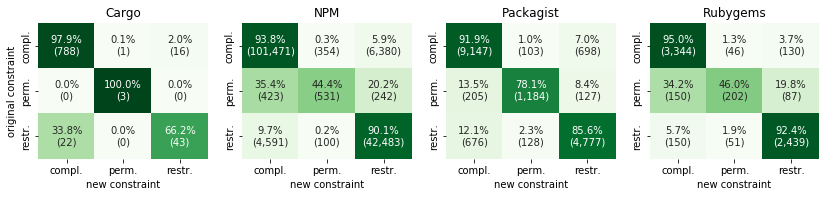

In [36]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=False)
fig.set_size_inches(FIG_SIZE_WIDE)

short_names = {
    'compliant': 'compl.',
    'permissive': 'perm.', 
    'restrictive': 'restr.',
}

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    labels = (
        data[ecosystem]
        .apply(lambda s: s / s.sum(), axis=1)
        .reset_index()
        .set_index('kind')
        .fillna(0)
        [['compliant', 'permissive', 'restrictive']]
        .loc[['compliant', 'permissive', 'restrictive']]
        .rename(columns=short_names, index=short_names)
        .applymap(lambda s: '{:.1%}\n'.format(s))
    ) + (
        data[ecosystem]
        .reset_index()
        .set_index('kind')
        .fillna(0)
        [['compliant', 'permissive', 'restrictive']]
        .loc[['compliant', 'permissive', 'restrictive']]
        .rename(columns=short_names, index=short_names)
        .applymap(lambda s: '({:,d})'.format(int(s)))
    ) 
    
    seaborn.heatmap(
        (
            data[ecosystem]
            .apply(lambda s: s / s.sum(), axis=1)
            .reset_index()
            .set_index('kind')
            .fillna(0)
            [['compliant', 'permissive', 'restrictive']]
            .loc[['compliant', 'permissive', 'restrictive']]
            .rename(columns=short_names, index=short_names)
        ),
        cmap='Greens',
        cbar=False,
        annot=labels,
        fmt='s',
        center=0.5,
        ax=ax
    )
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        # tick.set_horizontalalignment('right')
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)
        tick.set_verticalalignment('center')
    
    ax.set(
        title=ecosystem,
        xlabel='new constraint',
        ylabel='original constraint' if i == 0 else '',
    )
    
savefig(fig, 'change_proportion_original_new')

# Constraint specialization

A package is said to be *specialized* if a large proportion of its reverse dependencies agree on their constraints (i.e. they are either compliant, permissive or restrictive).

## A kind of "preferential attachment"

Compare the situation on 2017-01-01 and during 2017.

In [37]:
data = []

for ecosystem in ECOSYSTEMS:
    _ = (
        df_dependencies[ecosystem]
        [lambda d: d['date'] < pandas.to_datetime('2017-01-01')]
        .sort_values('rank')
        .drop_duplicates(['package', 'target'], keep='last')
        .assign(dependents=1)
        .groupby('target')
        [['compliant', 'permissive', 'restrictive', 'dependents']]
        .sum()
        .apply(lambda s: s / s['dependents'], axis=1)
        .drop(columns='dependents')
    ).merge(
        (
            df_dependencies[ecosystem]
            [lambda d: d['date'].between(pandas.to_datetime('2017-01-01'), pandas.to_datetime('2018-01-01'))]
            .assign(dependents=1)
            .groupby('target')
            [['compliant', 'permissive', 'restrictive', 'dependents']]
            .sum()
            .apply(lambda s: s / s['dependents'], axis=1)
            .drop(columns='dependents')
        ),
        how='inner', 
        left_index=True,
        right_index=True,
        suffixes=('', '_new')
    )
    
    data.append((
        ecosystem, 
        pearsonr(_['compliant'], _['compliant_new']),
        pearsonr(_['permissive'], _['permissive_new']),
        pearsonr(_['restrictive'], _['restrictive_new']),
    ))

pandas.DataFrame(data, columns=['ecosystem', 'compliant', 'permissive', 'restrictive'])

,ecosystem,compliant,permissive,restrictive
0,Cargo,"(0.8964158782287686, 0.0)","(0.9017038965789848, 0.0)","(0.7740968197221936, 6.878161686292471e-306)"
1,NPM,"(0.7365312508301882, 0.0)","(0.8174696285282435, 0.0)","(0.6333925505189816, 0.0)"
2,Packagist,"(0.7348374481934415, 0.0)","(0.7874829847038693, 0.0)","(0.6583206990626854, 0.0)"
3,Rubygems,"(0.6744312730922137, 0.0)","(0.7479528214661957, 0.0)","(0.6387807325006959, 0.0)"


## Proportion of required packages that are specialized

For this analysis, we restricted the set of packages that were active after 2017-01-01, and we consider the dependencies of the highest available version of each package during this period. Finally, we restricted the set of *required packages* to the one that are at least required by 2 other packages with non pre-1.0.0 constraints.

In [104]:
threshold = 0.95
min_required = 2

In [223]:
dates = pandas.date_range('2013-01-01', '2018-03-01', freq='1M')
data = dict()

for ecosystem in ECOSYSTEMS:
    data[ecosystem] = []
    
    df_temp = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        .sort_values('date')
    )
    
    for date in reversed(dates):
        df_temp = df_temp[lambda d: d['date'] <= date]
        
        data[ecosystem].append(
            df_temp
            [lambda d: d['date'].between(date - pandas.Timedelta('365D'), date)]
            .drop_duplicates(['package'], keep='last')
            .assign(dependents=1)
            .groupby('target', sort=False)
            [['dependents', 'compliant', 'permissive', 'restrictive']]
            .sum()
            [lambda d: d['dependents'] >= min_required]
            .reset_index(level='target', drop=True)
            .assign(
                compliant=lambda d: d['compliant'] >= threshold * d['dependents'],
                permissive=lambda d: d['permissive'] >= threshold * d['dependents'],
                restrictive=lambda d: d['restrictive'] >= threshold * d['dependents'],
            )
            .drop(columns=['dependents'])
            .assign(required=1)
            .sum()
            .rename(date)
        )

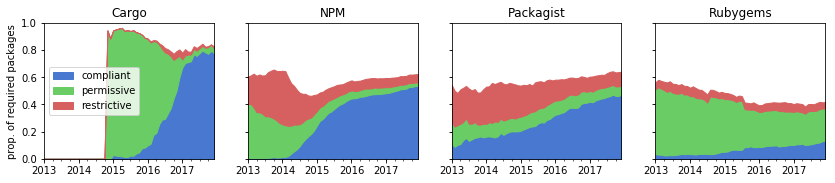

In [224]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    (
        pandas.DataFrame(data[ecosystem])
        .apply(lambda d: d / d['required'], axis=1)
        [['compliant', 'permissive', 'restrictive']]
        .plot(kind='area', ax=ax, stacked=True, legend=False, style=' ', color=SEC_PALETTE)
    )
        
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='prop. of required packages',
        ylim=(0, 1),
    )
    
axes[0].legend(loc='center left')
savefig(fig, 'required_specialized_snapshots')

In [239]:
pandas.concat([
    pandas.DataFrame(data[ecosystem])
    .apply(lambda d: d / d['required'], axis=1)
    [['compliant', 'permissive', 'restrictive']]
    .describe()
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
).loc[['mean', '50%']]

,compliant,permissive,restrictive,ecosystem
mean,0.367813,0.481747,0.014296,Cargo
mean,0.294023,0.129790,0.153067,NPM
mean,0.283553,0.100103,0.186228,Packagist
mean,0.071374,0.336615,0.054975,Rubygems
50%,0.290970,0.504181,0.008548,Cargo
50%,0.375134,0.076678,0.087485,NPM
50%,0.263040,0.100466,0.195344,Packagist
50%,0.076050,0.315325,0.054687,Rubygems


In [179]:
pandas.concat([
    pandas.DataFrame(data[ecosystem])
    .assign(ecosystem=ecosystem)
    .loc[pandas.to_datetime('2017-12-31')]
    for ecosystem in ECOSYSTEMS], axis=1
).T.set_index('ecosystem').apply(lambda s: s / s['required'], axis=1)#.cumsum(axis=1)

,compliant,permissive,restrictive,required
ecosystem,,,,
Cargo,0.778571,0.035714,0.014286,1.0
NPM,0.536380,0.026100,0.060935,1.0
Packagist,0.477888,0.063976,0.099614,1.0
Rubygems,0.133641,0.235945,0.047926,1.0


Some examples of specialized packages:

In [210]:
ecosystem = 'Cargo'
kind = 'compliant'
date = pandas.to_datetime('2017-12-31')

(
    df_dependencies[ecosystem]
    [lambda d: ~d['dev']]
    [lambda d: d['date'].between(date - pandas.Timedelta('365D'), date)]
    .drop_duplicates(['package'], keep='last')
    .assign(dependents=1)
    .groupby('target', sort=False)
    [['dependents', 'compliant', 'permissive', 'restrictive']]
    .sum()
    [lambda d: d['dependents'] >= min_required]
    [lambda d: d[kind] >= threshold * d['dependents']]
    .sort_values('dependents', ascending=False)
    .head(6)
)

,dependents,compliant,permissive,restrictive
target,,,,
serde,592,575.0,0.0,17.0
byteorder,297,289.0,1.0,7.0
serde_json,222,219.0,0.0,3.0
url,155,149.0,0.0,6.0
serde_derive,126,125.0,0.0,1.0
bitflags,100,100.0,0.0,0.0


Some examples of unspecialized packages:

In [215]:
ecosystem = 'Rubygems'
date = pandas.to_datetime('2017-12-31')

(
    df_dependencies[ecosystem]
    [lambda d: ~d['dev']]
    [lambda d: d['date'].between(date - pandas.Timedelta('365D'), date)]
    .drop_duplicates(['package'], keep='last')
    .assign(dependents=1)
    .groupby('target', sort=False)
    [['dependents', 'compliant', 'permissive', 'restrictive']]
    .sum()
    [lambda d: d['dependents'] >= min_required]
    [
        lambda d: (d['compliant'] < threshold * d['dependents']) 
        & (d['permissive'] < threshold * d['dependents']) 
        & (d['restrictive'] < threshold * d['dependents']) 
    ]
    .sort_values('dependents', ascending=False)
    .head(6)
)

,dependents,compliant,permissive,restrictive
target,,,,
rails,997,288.0,506.0,203.0
activesupport,771,226.0,469.0,76.0
nokogiri,493,212.0,194.0,87.0
rest-client,387,173.0,137.0,77.0
activerecord,369,133.0,207.0,29.0
json,364,145.0,177.0,42.0


### Offline recommender validation

We look at specialized packages for a snapshot, and then we look at the proportion of new constraints that adhere to this specialization during the next year.

In [148]:
snapshot = pandas.to_datetime('2017-01-01')

specialized = dict()

for ecosystem in ECOSYSTEMS:
    specialized[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        [lambda d: d['date'].between(snapshot - pandas.Timedelta('365D'), snapshot)]
        .sort_values('rank')
        .drop_duplicates(['package', 'target'], keep='last')
        .assign(dependents=1)
        .groupby('target')
        [['compliant', 'permissive', 'restrictive', 'dependents']]
        .sum()
        [lambda d: d['dependents'] >= min_required]
        .apply(lambda s: s / s['dependents'], axis=1)
        .drop(columns=['dependents'])
        .assign(kind=lambda d: d.idxmax(axis=1))
        .assign(score=lambda d: d.max(axis=1))
        [lambda d: d['score'] >= threshold]
    )

In [196]:
new_constraints = dict()

for ecosystem in ECOSYSTEMS:
    new_constraints[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        [lambda d: d['date'].between(snapshot, snapshot + pandas.Timedelta('365D'))]
        .assign(dependents=1)
        .groupby('target')
        [['compliant', 'permissive', 'restrictive', 'dependents']]
        .sum()
    )

In [197]:
# Now compare specialized packages vs. new constraints

data = []

for ecosystem in ECOSYSTEMS:
    for row in (
            specialized[ecosystem]
            .merge(
                new_constraints[ecosystem],
                how='inner', 
                left_index=True,
                right_index=True,
                suffixes=('', '_new')
            )
        ).itertuples():

        data.append((
            ecosystem,
            row.kind,
            getattr(row, row.kind + '_new') / row.dependents,
        ))

data = pandas.DataFrame(data, columns=['ecosystem', 'kind', 'score'])

#### Score

In [198]:
data.groupby(['ecosystem', 'kind'])[['score']].mean()

score
ecosystem kind                 
Cargo     compliant    0.971774
          permissive   0.750086
          restrictive  0.823541
NPM       compliant    0.937038
          permissive   0.811557
          restrictive  0.785824
Packagist compliant    0.936950
          permissive   0.807513
          restrictive  0.821525
Rubygems  compliant    0.904365
          permissive   0.933637
          restrictive  0.827338

In [200]:
data.groupby(['kind'])[['score']].mean()

,score
kind,
compliant,0.936580
permissive,0.861403
restrictive,0.799512


In [201]:
data.groupby(['ecosystem'])[['score']].mean()

,score
ecosystem,
Cargo,0.915829
NPM,0.910732
Packagist,0.897262
Rubygems,0.915482


In [202]:
data[['score']].mean()

score    0.908385
dtype: float64